In [41]:
import pandas as pd
import numpy as np
import scipy.optimize as sco

# Load your dataset
data = pd.read_csv('data/wls_data_2023_to_2024.csv', index_col='Date', parse_dates=True)
data = data.iloc[:, :1000]  # Select first 10 columns (companies)
data

,AAPL UW Equity,MSFT UW Equity,NVDA UW Equity,AMZN UW Equity,META UW Equity,GOOGL UW Equity,LLY UN Equity,GOOG UW Equity,AVGO UW Equity,2330 TT Equity,...,TATA IS Equity,SCG AT Equity,006400 KP Equity,CPT UN Equity,REG UW Equity,HLMA LN Equity,YUMC UN Equity,AES UN Equity,NDSN UW Equity,601899 C1 Equity
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,119.25,NaN,602000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,125.07,239.58,14.315,85.82,124.74,89.12,364.99,89.70,55.348,453.0,...,118.45,2.88,605000.0,110.68,62.83,2030.0,56.42,28.11,238.03,10.53
2023-01-04,126.36,229.10,14.749,85.14,127.37,88.08,363.10,88.71,56.024,449.5,...,115.75,2.91,603000.0,112.75,63.69,2076.0,58.65,27.28,237.75,10.30
2023-01-05,125.02,222.31,14.265,83.12,126.94,86.20,358.92,86.77,55.502,458.5,...,116.55,2.90,583000.0,109.67,62.29,2057.0,58.04,25.87,229.74,10.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-25,226.37,432.11,123.510,192.53,568.31,161.49,924.56,162.99,175.520,1005.0,...,161.66,3.65,381500.0,126.16,72.40,2596.0,38.19,19.53,255.59,16.92
2024-09-26,227.52,431.31,124.040,191.16,567.84,162.73,909.32,163.83,178.090,1015.0,...,165.61,3.71,387500.0,124.37,70.92,2594.0,43.86,19.64,260.96,17.37
2024-09-27,227.79,428.02,121.400,187.97,567.36,163.95,877.79,165.29,172.690,1000.0,...,166.55,3.67,384000.0,123.71,71.45,2655.0,45.35,20.07,261.66,17.51


In [42]:
def print_result(selected_stocks,
                 selected_returns,
                 total_investment,
                 optimal_weights,
                 portfolio_return,
                 portfolio_stddev,
                 sharpe_ratio):

    # Create a DataFrame for optimal weights and allocation
    result_df = pd.DataFrame({
        'Stock': selected_stocks,
        'Optimal Weight': optimal_weights,
        'Allocation ($)': total_investment * optimal_weights
    })

    # Display the results in a structured table
    print("\nOptimal Weights and Allocation ($500,000 Total):")
    print(result_df.to_string(index=False))  # Remove the index for cleaner output

    # Print portfolio performance metrics
    print(f"\nPortfolio Performance:")
    print(f"Expected Annual Return: {portfolio_return:.2%}")
    print(f"Expected Annual Volatility: {portfolio_stddev:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

In [ ]:

# Step 1: Calculate daily returns for the dataset
data_filled = data.fillna(method='ffill')  # Forward-fill missing values
returns = data_filled.pct_change().dropna()

# Step 2: Calculate one-day lagged correlation

def calculate_lagged_correlation(returns):
    freq = 10
    count = 0
    
    lagged_correlation = pd.DataFrame(index=returns.columns, columns=returns.columns)
    for stock1 in returns.columns:
        count += 1
        if (count % freq) == 0:
            print(count)

        for stock2 in returns.columns:
            if stock1 != stock2:
                lagged_correlation.loc[stock1, stock2] = returns[stock1].corr(returns[stock2].shift(1).dropna())
    return lagged_correlation.astype(float)

lagged_corr = calculate_lagged_correlation(returns)

# Step 3: Select top 5 pairs with the highest lagged correlation
pairs = lagged_corr.unstack().sort_values(ascending=False).dropna().head(5)
print("Selected top 5 pairs based on one-day lagged correlation:")
print(pairs)

# Step 4: Define Sharpe Ratio calculation for the portfolio
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.sum(mean_returns * weights) * 252  # Annualized return
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized risk
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev
    return portfolio_return, portfolio_stddev, sharpe_ratio

# Step 5: Optimize portfolio weights to maximize Sharpe ratio
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.0406):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    
    # Constraints: sum of weights is 1, each weight >= 0
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    
    # Initial guess (equal weights)
    result = sco.minimize(lambda weights: -portfolio_performance(weights, *args)[2],
                          num_assets * [1. / num_assets], 
                          method='SLSQP', 
                          bounds=bounds, 
                          constraints=constraints)
    
    return result

# Extract the top 5 pairs' stock data
selected_stocks = [stock for pair in pairs.index for stock in pair]
selected_returns = returns[selected_stocks]

# Calculate mean returns and covariance matrix for the selected stocks
mean_returns = selected_returns.mean()
cov_matrix = selected_returns.cov()

# Step 6: Optimize weights for maximum Sharpe ratio
opt_result = max_sharpe_ratio(mean_returns, cov_matrix)

# Optimal weights
optimal_weights = opt_result.x

# Portfolio performance with optimal weights
portfolio_return, portfolio_stddev, sharpe_ratio = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

# Step 7: Allocate $500,000 based on optimized weights
total_investment = 500000
allocation = total_investment * optimal_weights

print_result(selected_stocks, selected_returns, total_investment, optimal_weights, portfolio_return, portfolio_stddev, sharpe_ratio)


C:\Users\Alexander\AppData\Local\Temp\ipykernel_13424\4257605159.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_filled = data.fillna(method='ffill')  # Forward-fill missing values


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870


### With backtesting

C:\Users\Alexander\AppData\Local\Temp\ipykernel_13424\919084602.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_filled = data.fillna(method='ffill')  # Forward-fill missing values


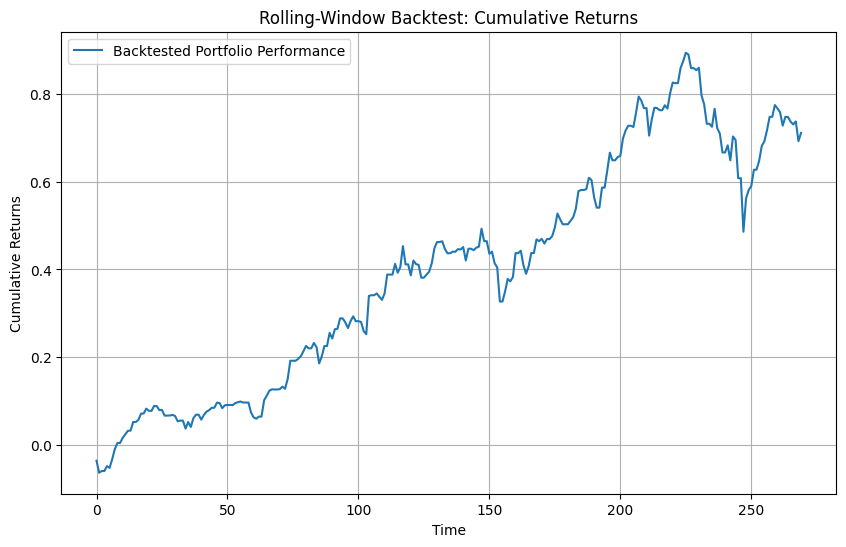


Optimal Weights and Allocation ($500,000 Total):
          Stock  Optimal Weight  Allocation ($)
 AVGO UW Equity    1.243314e-17    6.216571e-12
 2330 TT Equity    1.036961e-01    5.184805e+04
 NVDA UW Equity    2.419581e-01    1.209790e+05
 2330 TT Equity    1.036961e-01    5.184805e+04
 AMZN UW Equity    1.667429e-01    8.337143e+04
 2330 TT Equity    1.036961e-01    5.184805e+04
 MSFT UW Equity    4.541322e-03    2.270661e+03
 2330 TT Equity    1.036961e-01    5.184805e+04
GOOGL UW Equity    6.827723e-02    3.413861e+04
 2330 TT Equity    1.036961e-01    5.184805e+04

Portfolio Performance:
Expected Annual Return: 45.70%
Expected Annual Volatility: 21.75%
Sharpe Ratio: 2.05


In [37]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('data/wls_data_2023_to_2024.csv', index_col='Date', parse_dates=True)
data = data.iloc[:, :10]  # Select first 10 columns (companies)
data

# Step 1: Calculate daily returns
data_filled = data.fillna(method='ffill')  # Forward-fill missing values
returns = data_filled.pct_change().dropna()

# Step 2: Define function to calculate one-day lagged correlation
def calculate_lagged_correlation(returns):
    lagged_correlation = pd.DataFrame(index=returns.columns, columns=returns.columns)
    for stock1 in returns.columns:
        for stock2 in returns.columns:
            if stock1 != stock2:
                lagged_correlation.loc[stock1, stock2] = returns[stock1].corr(returns[stock2].shift(1).dropna())
    return lagged_correlation.astype(float)

# Step 3: Define Sharpe Ratio calculation and portfolio optimization functions
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev
    return portfolio_return, portfolio_stddev, sharpe_ratio

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.01):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = sco.minimize(lambda weights: -portfolio_performance(weights, *args)[2],
                          num_assets * [1. / num_assets], 
                          method='SLSQP', 
                          bounds=bounds, 
                          constraints=constraints)
    return result

# Step 4: Rolling Window Backtesting
window_size = 252  # One year window
test_window_size = 90  # 3 months for testing
total_investment = 500000
portfolio_returns = []

for start in range(0, len(returns) - window_size - test_window_size, test_window_size):
    # Train data (1 year)
    train_returns = returns.iloc[start:start + window_size]
    lagged_corr = calculate_lagged_correlation(train_returns)
    
    # Select top 5 pairs based on lagged correlation
    pairs = lagged_corr.unstack().sort_values(ascending=False).dropna().head(5)
    selected_stocks = [stock for pair in pairs.index for stock in pair]
    selected_returns = train_returns[selected_stocks]
    
    # Calculate mean returns and covariance matrix for the selected stocks
    mean_returns = selected_returns.mean()
    cov_matrix = selected_returns.cov()
    
    # Optimize weights for maximum Sharpe ratio
    opt_result = max_sharpe_ratio(mean_returns, cov_matrix)
    optimal_weights = opt_result.x
    
    # Test data (next 3 months)
    test_returns = returns.iloc[start + window_size:start + window_size + test_window_size][selected_stocks]
    test_portfolio_returns = np.dot(test_returns, optimal_weights)
    
    # Store portfolio returns for this test window
    portfolio_returns.extend(test_portfolio_returns)

# Step 5: Calculate performance metrics over the whole backtest period
portfolio_returns = np.array(portfolio_returns)
cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Backtested Portfolio Performance")
plt.title("Rolling-Window Backtest: Cumulative Returns")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


# Calculate final portfolio performance metrics
final_mean_returns = np.mean(returns[selected_stocks])
final_cov_matrix = np.cov(returns[selected_stocks].T)
portfolio_return, portfolio_stddev, sharpe_ratio = portfolio_performance(optimal_weights, final_mean_returns, final_cov_matrix)

print_result(selected_stocks, selected_returns, total_investment, optimal_weights, portfolio_return, portfolio_stddev, sharpe_ratio)


### With momentum

C:\Users\Alexander\AppData\Local\Temp\ipykernel_13424\435701547.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_filled = data.fillna(method='ffill')  # Forward-fill missing values


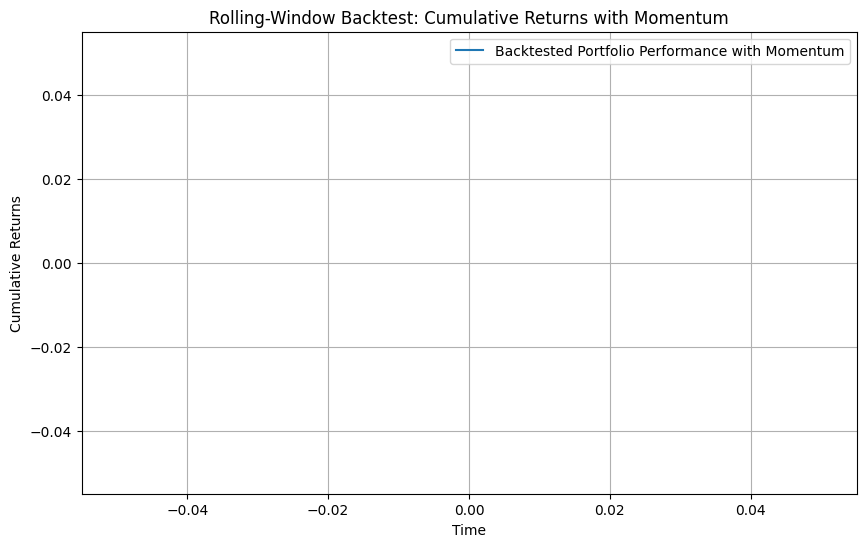

In [36]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('data/wls_data_2023_to_2024.csv', index_col='Date', parse_dates=True)
data = data.iloc[:, :10]  # Select first 10 columns (companies)
data

# Step 1: Calculate daily returns for the dataset
data_filled = data.fillna(method='ffill')  # Forward-fill missing values
returns = data_filled.pct_change().dropna()

# Step 2: Define function to calculate one-day lagged correlation
def calculate_lagged_correlation(returns):
    lagged_correlation = pd.DataFrame(index=returns.columns, columns=returns.columns)
    for stock1 in returns.columns:
        for stock2 in returns.columns:
            if stock1 != stock2:
                lagged_correlation.loc[stock1, stock2] = returns[stock1].corr(returns[stock2].shift(1).dropna())
    return lagged_correlation.astype(float)

# Step 3: Define Sharpe Ratio calculation and portfolio optimization functions
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev
    return portfolio_return, portfolio_stddev, sharpe_ratio

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.01):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = sco.minimize(lambda weights: -portfolio_performance(weights, *args)[2],
                          num_assets * [1. / num_assets], 
                          method='SLSQP', 
                          bounds=bounds, 
                          constraints=constraints)
    return result

# Step 4: Define a momentum strategy (SMA crossover)
def calculate_momentum(returns, window=50):
    prices = (1 + returns).cumprod()
    sma = prices.rolling(window=window).mean()
    momentum_signal = (prices > sma).astype(int)  # 1 if price > SMA (positive momentum), else 0
    return momentum_signal

# Step 5: Rolling Window Backtesting with Momentum
window_size = 252  # One year window
test_window_size = 90  # 3 months for testing
total_investment = 500000
portfolio_returns = []

for start in range(0, len(returns) - window_size - test_window_size, test_window_size):
    # Train data (1 year)
    train_returns = returns.iloc[start:start + window_size]
    lagged_corr = calculate_lagged_correlation(train_returns)
    
    # Select top 5 pairs based on lagged correlation
    pairs = lagged_corr.unstack().sort_values(ascending=False).dropna().head(5)
    selected_stocks = [stock for pair in pairs.index for stock in pair]
    selected_returns = train_returns[selected_stocks]
    
    # Calculate mean returns and covariance matrix for the selected stocks
    mean_returns = selected_returns.mean()
    cov_matrix = selected_returns.cov()
    
    # Optimize weights for maximum Sharpe ratio
    opt_result = max_sharpe_ratio(mean_returns, cov_matrix)
    optimal_weights = opt_result.x
    
    # Test data (next 3 months)
    test_returns = returns.iloc[start + window_size:start + window_size + test_window_size][selected_stocks]
    
    # Step 6: Combine lagged correlation signals with momentum signals
    # Calculate momentum signal (SMA crossover) for the selected stocks
    momentum_signal = calculate_momentum(test_returns)
    
    # Adjust returns based on momentum: Only trade if momentum signal is positive
    adjusted_returns = test_returns[momentum_signal == 1]
    
    # Calculate portfolio returns for the test window
    test_portfolio_returns = np.dot(adjusted_returns, optimal_weights)
    
    # Store portfolio returns for this test window
    portfolio_returns.extend(test_portfolio_returns)

# Step 7: Calculate performance metrics over the whole backtest period
portfolio_returns = np.array(portfolio_returns)
cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Backtested Portfolio Performance with Momentum")
plt.title("Rolling-Window Backtest: Cumulative Returns with Momentum")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


#### With rolling window

In [35]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('data/wls_data_2023_to_2024.csv', index_col='Date', parse_dates=True)
data = data.iloc[:, :10]  # Select first 10 columns (companies)
data

# Step 1: Calculate daily returns
data_filled = data.ffill()  # Forward-fill missing values
returns = data_filled.pct_change().dropna()

# Step 2: Define function to calculate one-day lagged correlation
def calculate_lagged_correlation(returns):
    lagged_correlation = pd.DataFrame(index=returns.columns, columns=returns.columns)
    for stock1 in returns.columns:
        for stock2 in returns.columns:
            if stock1 != stock2:
                lagged_correlation.loc[stock1, stock2] = returns[stock1].corr(returns[stock2].shift(1).dropna())
    return lagged_correlation.astype(float)

# Step 3: Define Sharpe Ratio calculation and portfolio optimization functions
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev
    return portfolio_return, portfolio_stddev, sharpe_ratio

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.01):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = sco.minimize(lambda weights: -portfolio_performance(weights, *args)[2],
                          num_assets * [1. / num_assets], 
                          method='SLSQP', 
                          bounds=bounds, 
                          constraints=constraints)
    return result

# Step 4: Rolling Window Backtesting
window_size = 180  # One year window
test_window_size = 60  # 3 months for testing
total_investment = 500000
portfolio_returns = []
dates = returns.index  # Store dates for plotting
split_dates = []

for start in range(0, len(returns) - window_size - test_window_size, test_window_size):
    # Train data (1 year)
    train_returns = returns.iloc[start:start + window_size]
    lagged_corr = calculate_lagged_correlation(train_returns)
    
    # Select top 5 pairs based on lagged correlation
    pairs = lagged_corr.unstack().sort_values(ascending=False).dropna().head(5)
    selected_stocks = [stock for pair in pairs.index for stock in pair]
    selected_returns = train_returns[selected_stocks]
    
    # Calculate mean returns and covariance matrix for the selected stocks
    mean_returns = selected_returns.mean()
    cov_matrix = selected_returns.cov()
    
    # Optimize weights for maximum Sharpe ratio
    opt_result = max_sharpe_ratio(mean_returns, cov_matrix)
    optimal_weights = opt_result.x
    
    # Test data (next 3 months)
    test_returns = returns.iloc[start + window_size:start + window_size + test_window_size][selected_stocks]
    test_portfolio_returns = np.dot(test_returns, optimal_weights)
    
    # Store portfolio returns for this test window
    portfolio_returns.extend(test_portfolio_returns)
    
    # Store the start date of the test data to plot a vertical line
    split_dates.append(dates[start + window_size])

# Step 5: Calculate performance metrics over the whole backtest period
portfolio_returns = np.array(portfolio_returns)
cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

# Step 6: Calculate Equal-Weighted Portfolio Returns
equal_weights = np.full(len(selected_stocks), 1 / len(selected_stocks))  # Equal weights for all stocks
equal_weighted_returns = np.dot(returns[selected_stocks], equal_weights)

# Step 7: Calculate WLS Stock Index Returns (assuming 'WLS_Index' is a column in the dataset)
wls_index_returns = data['WLS_Index'].pct_change().dropna()
cumulative_wls_index_returns = np.cumprod(1 + wls_index_returns) - 1

# Calculate cumulative returns for the equal-weighted portfolio
cumulative_equal_returns = np.cumprod(1 + equal_weighted_returns) - 1

# Plot cumulative returns with dates and vertical lines for splits
plt.figure(figsize=(10, 6))
plt.plot(dates[window_size:], cumulative_returns, label="Backtested Portfolio Performance")

# Add vertical lines for test data splits
for split_date in split_dates:
    plt.axvline(x=split_date, color='r', linestyle='--', alpha=0.5, label='Test Data Split')

# Plot cumulative returns for the optimized portfolio, equal-weighted portfolio, and WLS index
plt.figure(figsize=(10, 6))
plt.plot(dates[window_size:], cumulative_returns, label="Optimized Portfolio Performance")
plt.plot(dates[window_size:], cumulative_equal_returns, label="Equal-Weighted Portfolio", linestyle='--')
plt.plot(wls_index_returns.index, cumulative_wls_index_returns, label="WLS Index", linestyle='-.')
plt.title("Portfolio Performance Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

# Calculate final portfolio performance metrics
final_mean_returns = np.mean(returns[selected_stocks])
final_cov_matrix = np.cov(returns[selected_stocks].T)
portfolio_return, portfolio_stddev, sharpe_ratio = portfolio_performance(optimal_weights, final_mean_returns, final_cov_matrix)

# Print final results using the print_result function
def print_result(selected_stocks,
                 selected_returns,
                 total_investment,
                 optimal_weights,
                 portfolio_return,
                 portfolio_stddev,
                 sharpe_ratio):

    # Create a DataFrame for optimal weights and allocation
    result_df = pd.DataFrame({
        'Stock': selected_stocks,
        'Optimal Weight': optimal_weights,
        'Allocation ($)': total_investment * optimal_weights
    })

    # Display the results in a structured table
    print("\nOptimal Weights and Allocation ($500,000 Total):")
    print(result_df.to_string(index=False))  # Remove the index for cleaner output

    # Print portfolio performance metrics
    print(f"\nPortfolio Performance:")
    print(f"Expected Annual Return: {portfolio_return:.2%}")
    print(f"Expected Annual Volatility: {portfolio_stddev:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Print results
print_result(selected_stocks, selected_returns, total_investment, optimal_weights, portfolio_return, portfolio_stddev, sharpe_ratio)


KeyError: 'WLS_Index'